# Project:Sentiment Classification

### Pre read notes

1.   Keras in Tensforflow on Google colab (GC) has been used for this exercise.
2. The project is for sentiment classification and this belongs to 'many to one' type of problem in NLP.
3. Only the first 20 words in a review sentence is  used for model ( as given in the project instruction)
4. As an approach, simple LSTM is first evaluated. Then Bidirectional LSTM is evaluated ( even though this is 'many to one' type problem). Then model is regularized to avoid overfitting.

In [ ]:
%tensorflow_version 2.x

### Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

# libraries for basic utility functions and array handling
import os 
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# libraries for preprocessing, model building, and evaluation 

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import  Dense , Embedding,Input, LSTM, SpatialDropout1D,Bidirectional,GlobalMaxPool1D
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow import random
from sklearn import metrics
print ('Tensorflow version:',tf.__version__)

Using TensorFlow backend.


Tensorflow version: 2.2.0-rc2


## Set up drive and folder

In [3]:
# mounting the drive on Google Colab
from google.colab import drive
drive.mount('/content/drive')

# changing the directory to point to project folder
os.chdir('/content/drive/My Drive/AIML/Projects/NLP')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load the dataset , import train and test data/labels

In [4]:
#loading the imdb dataset with the parameter values set as below
seed=9
vocab_size = 10000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size,seed=seed,start_char=1,oov_char=2,index_from=3) 

17465344/17464789 [==============================] - 0s 0us/step


In [5]:
#check the shape of dataset loaded
print('X_train dataset shape:',X_train.shape)
print('y_train dataset shape:',y_train.shape)
print('X_test dataset shape:',X_test.shape)
print('y_test dataset shape:',y_test.shape)

X_train dataset shape: (25000,)
y_train dataset shape: (25000,)
X_test dataset shape: (25000,)
y_test dataset shape: (25000,)


1.   There are 25000 records for training and 25000 records for testing
2.   We will use the same dataset for training and testing respectively and will not do changes to the train test split ratio (50:50)



In [6]:
#checking few rows of data from X_train
print(X_train[0:5])

[list([1, 43, 385, 46, 7, 6, 4949, 4435, 18, 14, 22, 12, 69, 72, 1104, 175, 1088, 2, 4, 277, 16, 38, 163, 15, 1674, 71, 2660, 180, 61, 393, 5, 12, 69, 72, 4864, 13, 1869, 1247, 15, 1058, 6804, 50, 26, 407, 49, 2, 21, 444, 545, 441, 4, 20, 1625, 1230, 5329, 28, 6, 580, 8, 4091, 103, 3247, 4, 7603, 39, 199, 1240, 3937, 11, 1478, 8674, 5, 80, 8024, 9544, 4, 1795, 7, 2709, 2, 11, 68, 102, 723, 9076, 9, 642, 17, 210, 13, 119, 15, 29, 70, 30, 38, 163, 11, 134, 3826, 1290, 5, 1999, 8, 157, 11, 2689, 3287, 40, 1657, 590, 13, 104, 15, 7915, 2, 144, 30, 397, 53, 157, 88, 29, 38, 7113, 1020, 5, 1728, 2814, 4393, 82, 69, 49, 966, 163, 388, 13, 545, 386, 12, 18, 148, 37, 43, 181, 8, 462, 40, 6, 5049, 190, 48, 335, 714, 4154, 92, 67, 14, 20, 48, 335, 6, 2, 4944, 92, 67, 14, 20, 5, 591, 24, 551, 51, 60, 48, 25, 104, 335, 31, 7, 148, 2731, 846, 92, 193, 129, 362, 8, 14, 20, 252, 25, 144, 387, 129, 2521, 140, 67, 14, 20, 43, 92, 106, 12, 19, 98, 12, 62, 97, 18, 49, 966, 2094, 388])
 list([1, 14, 9, 6, 

In [7]:
#checking length of values for few rows in X_train
for i in range(0,5):
  print('Length of row index',i,'is',len(X_train[i]))

Length of row index 0 is 214
Length of row index 1 is 262
Length of row index 2 is 223
Length of row index 3 is 153
Length of row index 4 is 244


In [8]:
# since each row is of different length we will find the maximum length for any row in X_train
maxlen=-1
for i in range (0,len(X_train)):
    if(maxlen<len(X_train[i])):
        maxlen=len(X_train[i])
print("The maximum number of words in any row/document is : ",maxlen)

The maximum number of words in any row/document is :  2494


In [9]:
#checking unique values in y (train and test) and also the split of data between various y labels
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([12500, 12500]))
(array([0, 1]), array([12500, 12500]))




1.   The data seems to be balanced ( with 50% data with sentiment label as 0 and rest 50% with sentiment label 1)



In [ ]:
#make all sequences of the same length
maxlen = 20  
X_train = pad_sequences(X_train, maxlen=maxlen,padding='post', truncating='post',value=0)
X_test = pad_sequences(X_test, maxlen=maxlen,padding='post', truncating='post',value=0)

In [11]:
#check the shape of dataset 
print('X_train dataset shape:',X_train.shape)
print('y_train dataset shape:',y_train.shape)
print('X_test dataset shape:',X_test.shape)
print('y_test dataset shape:',y_test.shape)

X_train dataset shape: (25000, 20)
y_train dataset shape: (25000,)
X_test dataset shape: (25000, 20)
y_test dataset shape: (25000,)


In [12]:
#checking few rows of data from X_train
print(X_train[0:5])

[[   1   43  385   46    7    6 4949 4435   18   14   22   12   69   72
  1104  175 1088    2    4  277]
 [   1   14    9    6  184  680   20   12  127  266  638   17   35 2228
    22   19  120    4  350  567]
 [   1  466  321 4241   18 6742 1749   13   16 1017    8   30  685   34
     4   22   88  474  557   15]
 [   1   13  219 7976 6693 1453    5  210    4  172  547   25   67    4
  7522 5270   97  172   20   36]
 [   1   32 2515  140    8 1827    9   31    7    4  118  102  207  126
   110   13   86  219   12   54]]


1.   Each row of review is now represented in length of 20 words ( words already represented as indexed numbers)





## Build word dict and Keras Embedding Layer Model

In [13]:
#getting word index data from imdb dataset and creating dict. for word id

word_to_id = imdb.get_word_index()
word_to_id = {k:(v+3) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNKNOWN>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[0] ))
print(' '.join(id_to_word[id] for id in X_test[0] ))

1646592/1641221 [==============================] - 0s 0us/step
<START> just came out of a sneak preview for this film it had me laughing every 30 <UNKNOWN> the ending
<START> i have to agree with the previous author's comments about the excellent performances and plot started watching this movie


In [14]:
#model parameters - embedding 
input_dim=vocab_size
output_dim=32
input_length=maxlen

#defining model 
clear_session()

word_input= Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length)(word_input)
embed_model =Model([word_input],word_embedding) 

embed_model.compile(optimizer= Adam(lr=1e-3),loss='binary_crossentropy',metrics=['acc'])

print(embed_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 32)            320000    
Total params: 320,000
Trainable params: 320,000
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
#predicting embedding for X_test 
embeddings=embed_model.predict(X_test)
print("Shape of embeddings : ",embeddings.shape)

Shape of embeddings :  (25000, 20, 32)


In [16]:
#copying the embeddings for first 2 rows and output the encoding for each word of the 2 rows 
embed_sample = embeddings[0:2]
print("Shape of sample : ",embed_sample.shape)
for i,doc in enumerate(embed_sample):
    for j,word in enumerate(doc):
        print()
        print("The encoding for ",j+1,"word","in",i+1,"document is : \n",word)

Shape of sample :  (2, 20, 32)

The encoding for  1 word in 1 document is : 
 [ 0.04386171  0.02070225  0.0421308  -0.00891602  0.01651304  0.02387225
 -0.01797535 -0.00468678  0.02094293 -0.0254933  -0.04965603 -0.03299235
  0.02473836 -0.02423836 -0.00436568  0.01957205  0.04929722  0.03756702
 -0.00171905  0.04786489  0.03116927  0.01588223  0.04753988  0.04577662
  0.02455666  0.04832007 -0.01336414  0.00910617  0.00515661 -0.01764143
  0.04420337 -0.00387723]

The encoding for  2 word in 1 document is : 
 [ 0.01660788 -0.00438808  0.02679885 -0.02686133 -0.00552022 -0.02237105
  0.00972724 -0.01029619  0.01579661 -0.01603831 -0.03135706 -0.0418045
  0.03643625 -0.0244095   0.01565209 -0.03562337  0.00149268 -0.03504843
  0.03135511  0.02869928 -0.01369913  0.02433803  0.02533802 -0.01438489
 -0.04661667  0.02173171  0.01701662 -0.02809697 -0.02299073 -0.01080754
  0.02618934  0.04663909]

The encoding for  3 word in 1 document is : 
 [ 0.04850173  0.03657308 -0.03429065 -0.0175451

## Build LSTM classification Model

#### Simple LSTM classification Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 402,561
Trainable params: 402,561
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
250/250 - 16s - loss: 0.6045 - accuracy: 0.6574 - val_loss: 0.5640 - val_accuracy: 0.6988
Epoch 2/30
250/250 - 16s - loss: 0.4800 - accuracy: 0.7677 - val_loss: 0.5884 - val_accuracy: 0.6939
Epoch 3/30
250/250 - 15s - loss: 0.4267 - accuracy: 0.7999 - val_loss: 0.6000 - val_accuracy: 0.6912
Epoch 4/30
250/250 - 16s - loss: 0.3814 - accuracy: 0.8274 - val_loss: 0

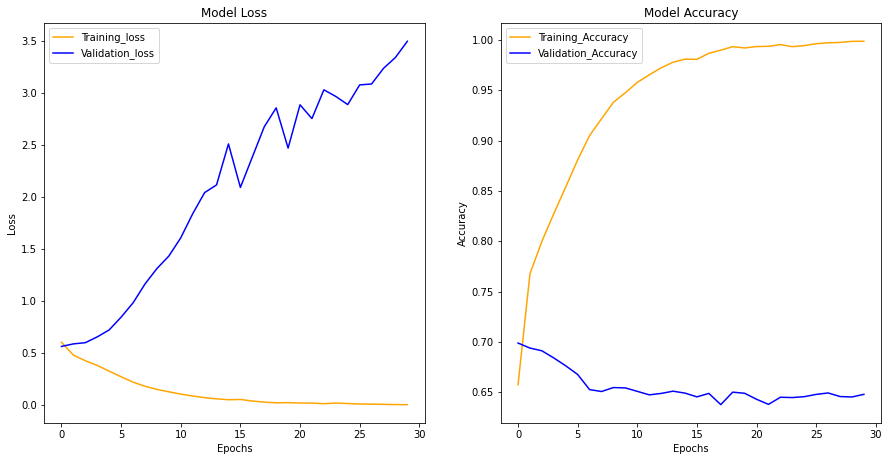

In [17]:
#setting model parameters
EPOCHS = 30
BATCH_SIZE = 100
lstm_out = 128
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True)
loss = 'binary_crossentropy'

#defining model - Simple LSTM
clear_session()

np.random.seed(seed)
random.set_seed(seed)

model = Sequential() 
model.add(Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length))
model.add(LSTM(lstm_out)) 
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=loss,optimizer=optimizer, metrics=['accuracy']) 

print(model.summary()) 

#fitting model - Simple LSTM
start_time=time.time()

model.fit(X_train, y_train,validation_data=(X_test,y_test),shuffle=True,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=2)

et=round(time.time()-start_time,2)
print()
print('Model fit completed in',et, 'seconds')

# printing the graph to visualize the loss and accuracy movement in training and test epoch runs
train_loss=val_loss=train_acc=val_acc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['accuracy']
val_acc    = model.history.history['val_accuracy']

figure_obj = plt.figure(figsize = (15,25))

epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)   
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss')

ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_acc, label='Training_Accuracy', color = 'orange')
ax2.plot(epochs, val_acc, label='Validation_Accuracy', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.title.set_text('Model Accuracy') 

#evaluating model - Simple LSTM
score, acc = model.evaluate(X_test, y_test,batch_size=BATCH_SIZE,verbose=0)
print('Test Accuracy  :%0.3f' %(acc))

1.   The model is performing extremely well on training set (with loss of 0.005 and accuracy of 0.99)
2.   However the performance on validation (test data) is very poor. The validation loss is only going up with validation accuracy going down.
1.   Test validation accuracy is at 64.8% and this clearly shows the model is overfitting and needs to be regularized.

#### Bi-directional LSTM classification Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           164864    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 501,377
Trainable params: 501,377
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
250/250 - 29s - loss: 0.6110 - accuracy: 0.6454 - val_loss: 0.5637 - val_accuracy: 0.7018
Epoch 2/30

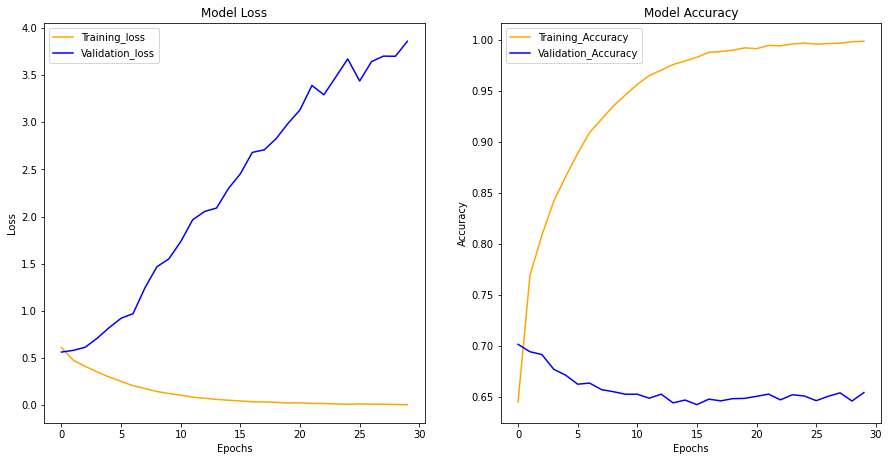

In [18]:
#setting model parameters
EPOCHS = 30
BATCH_SIZE = 100
lstm_out = 128
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True)
loss = 'binary_crossentropy'

#defining model - Bidirectional LSTM 
clear_session()

np.random.seed(seed)
random.set_seed(seed)

model = Sequential() 
model.add(Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length))
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss=loss,optimizer=optimizer, metrics=['accuracy']) 

print(model.summary())

#fitting the model - Bidirectional LSTM 
start_time=time.time()

model.fit(X_train, y_train,validation_data=(X_test,y_test),shuffle=True,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=2)

et=round(time.time()-start_time,2)
print()
print('Model fit completed in',et, 'seconds')

# printing the graph to visualize the loss and accuracy movement in training and test epoch runs
train_loss=val_loss=train_acc=val_acc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['accuracy']
val_acc    = model.history.history['val_accuracy']

figure_obj = plt.figure(figsize = (15,25))

epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)   
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss')

ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_acc, label='Training_Accuracy', color = 'orange')
ax2.plot(epochs, val_acc, label='Validation_Accuracy', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.title.set_text('Model Accuracy')  

#evaluating the model - Bidirectional LSTM 
score, acc = model.evaluate(X_test, y_test,batch_size=BATCH_SIZE,verbose=0)
print('Test Accuracy  :%0.3f' %(acc))

1.   The model is performing extremely well on training set (with loss of 0.006 and accuracy of 0.99)
2.   However the performance on validation (test data) is very poor. The validation loss is only going up with validation accuracy going down.
1.   Test validation accuracy is at 65.5% and this clearly shows the model is overfitting and needs to be regularized.
1.   Since the performance is equally good in simple LSTM and since this is 'many to one' type of problem, bi-directional LSTM may not be appropriate for this problem statement.
2.   Hence the simple LSTM model is taken further for regualization in further steps.
1.   Regualization is done using dropouts and l2 regularization values.
2.   Callback is implemented with early stopping based on validation loss and modelcheckpoint based on validation accuracy.


#### Simple LSTM classification Model - with Regularization

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 402,561
Trainable params: 402,561
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.51888, saving model to myNLPmodelwt.h5
250/250 - 20s - loss: 1.8987 - accuracy: 0.5197 - val_loss: 1.4385 - val_accuracy: 0.5189 - lr: 0.0010
Epoch 2/50

Epoch 00002: val_accuracy i

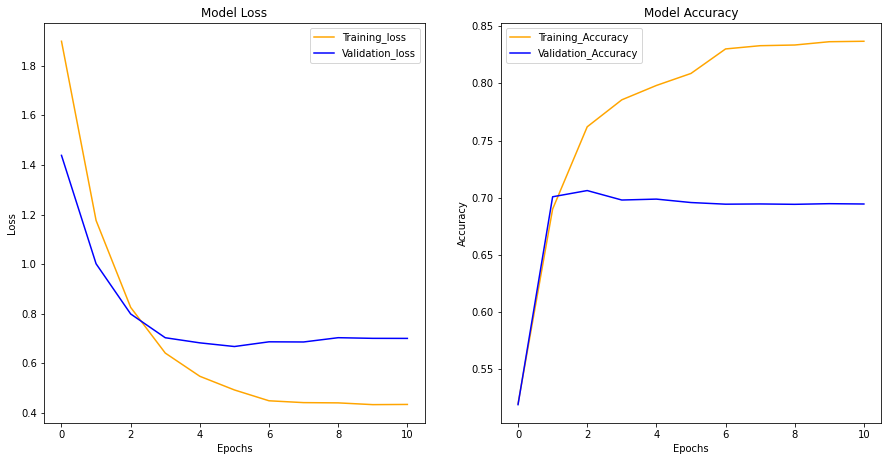

In [19]:
#setting model parameters
EPOCHS = 50
BATCH_SIZE = 100
lstm_out = 128
PATIENCE = 5
FILENAME='myNLPmodelwt.h5'
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=True)
loss = 'binary_crossentropy'
checkpoint = ModelCheckpoint(FILENAME, monitor="val_accuracy", verbose=1, save_best_only=True,save_weights_only=True, mode="max", save_freq='epoch')
stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, mode="min",min_delta=.01)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=3, min_lr=1e-6, verbose=0, mode="max")

#defining model - Simple LSTM with regualization (using Dropout and l2 regularization)
clear_session()

np.random.seed(seed)
random.set_seed(seed)

model = Sequential() 
model.add(Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss=loss,optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

#fitting the model - with callback enabled
start_time=time.time()

model.fit(X_train, y_train,validation_data=(X_test,y_test),shuffle=True,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=2,callbacks=[stop,checkpoint,reduce_lr])

et=round(time.time()-start_time,2)
print()
print('Model fit completed in',et, 'seconds')

# printing the graph to visualize the loss and accuracy movement in training and test epoch runs
train_loss=val_loss=train_acc=val_acc=None
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['accuracy']
val_acc    = model.history.history['val_accuracy']

figure_obj = plt.figure(figsize = (15,25))

epochs = range(0, len(train_loss))
ax1 = figure_obj.add_subplot(3,2,1)   
ax1.plot(epochs, train_loss, label='Training_loss', color = 'orange')
ax1.plot(epochs, val_loss, label='Validation_loss', color = 'blue')
ax1.legend(loc='best')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.title.set_text('Model Loss')

ax2 = figure_obj.add_subplot(3,2,2)
ax2.plot(epochs, train_acc, label='Training_Accuracy', color = 'orange')
ax2.plot(epochs, val_acc, label='Validation_Accuracy', color = 'blue')
ax2.legend(loc='best')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.title.set_text('Model Accuracy') 

1.   The validation loss and accuracy shows movement in tandem with training initially, though beyond certain epoch, the validation accuracy does not show improvement.
2.   The optimal model is at epoch 3 where training accuracy is at 76% and validation accuracy is at 70.6%.
1.   While from regularization standpoint, the model has clearly avoided overfitting, the overall validation accuracy is showing only improvement from 65% to 71%.
2.   Further tuning may be possible by improving the word length considered for model ( only 20 words considered), embedding length and tweaking dropout / l2 values etc.





## Evaluate LSTM classification Model

In [20]:
# evaluating the model.
model.load_weights(FILENAME)
score, acc = model.evaluate(X_test, y_test,batch_size=BATCH_SIZE,verbose=0)
print('Test Accuracy  :%0.3f' %(acc))

Test Accuracy  :0.706


In [21]:
# getting prediction values for X_test and see the results
y_pred = model.predict(X_test, verbose=0).reshape(-1)
print('Prediction before applying threshold:')
print(y_pred[0:10],end='\n\n')

# setting threshold values and getting the transformed prediction output results
y_predict = (y_pred>0.5).astype(int)
print('Prediction after applying threshold:')
print(y_predict[0:10])

Prediction before applying threshold:
[0.71401227 0.6551046  0.70642096 0.39724535 0.61937827 0.5239931
 0.50926244 0.66429895 0.2715905  0.5542374 ]

Prediction after applying threshold:
[1 1 1 0 1 1 1 1 0 1]


In [22]:
# evaluating the model (using sklearn metrics)
accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
print('Test Accuracy :%0.3f' %(accuracy_score))
print('Test Specificity :%0.3f' %(recall_score[1]),end='\n\n')

print('Classification Report:')
print(metrics.classification_report(y_test, y_predict),end='\n\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test,y_predict))

Test Accuracy :0.706
Test Specificity :0.742

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.67      0.70     12500
           1       0.69      0.74      0.72     12500

    accuracy                           0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000


Confusion Matrix:
[[8378 4122]
 [3223 9277]]


1.   Overall accuracy of the model ( based on test dataset) is 70.6%
2.   Specificity of the model ( based on test dataset) is 74.2%

## Retrieve the output of each layer in keras for a given single test sample from the trained model 

In [23]:
# copying 1 record from X_test to X_sample to run the prediction and retrive the output of each layers
X_sample = X_test[0:1].copy()
print('X_sample shape:',X_sample.shape)

# running prediction for the sample data and compare with actual values
y_sample = model.predict(X_sample, verbose=0).reshape(-1)
y_sample = (y_sample>0.5).astype(int)
print('Classification predicted by the model:',y_sample[0])
print('Actual classification:',y_test[0])

X_sample shape: (1, 20)
Classification predicted by the model: 1
Actual classification: 1


In [24]:
# retrieving the output of embedding, lstm and dense layers of the model for the sample record predicted
layer_list = ['embedding','lstm','dense']
for i in layer_list:
  layer_output=model.get_layer(i).output
  sample_model=Model(inputs=model.input,outputs=layer_output)
  sample_prediction=sample_model.predict(X_sample.reshape(1,20))
  print('Output of',i,'layer')
  print('Shape:',sample_prediction.shape)
  print(sample_prediction)
  print()

Output of embedding layer
Shape: (1, 20, 32)
[[[ 2.70271134e-02 -1.11578517e-02 -1.47662940e-03  2.83569675e-02
    1.06354719e-02  1.01955165e-03 -3.18031907e-02  2.97275390e-02
   -3.75753269e-02 -1.70377409e-03  2.74507403e-02  2.18579695e-02
   -7.29780132e-03  4.61342819e-02  2.25497112e-02 -1.27245318e-02
    9.79863480e-03  1.12641985e-02 -3.44533026e-02 -2.29869466e-02
   -9.59506538e-03  2.56033726e-02  1.16779543e-02  4.09311578e-02
   -3.19142677e-02 -1.92820597e-02  2.84445425e-03 -4.85294219e-03
   -3.17736454e-02  1.45141431e-03  4.85917274e-03  6.85901847e-03]
  [ 1.59812998e-02 -3.27364840e-02  1.36404419e-02 -2.05168687e-02
   -9.09050112e-04  1.81358848e-02 -5.91332046e-03 -1.19600631e-02
    4.15837429e-02  4.60053831e-02  1.04621062e-02  3.17383893e-02
   -7.37014506e-03 -2.78447811e-02  1.25343101e-02 -3.10254525e-02
   -4.12877707e-05 -8.72571021e-03 -2.25411244e-02  5.53126149e-02
    1.80504825e-02  2.23357999e-03  4.12083603e-02 -2.94928793e-02
    6.28023744e-

 

1.   The embedding layer output shows how the input (1 review document/row) is converted to vector of size 20,32 with 20 representing the 20 words of the review and 32 representing the embedding values for each one of these 20 words.
2.   The lstm layer output shows the output of 128 lstm units.
1.   The output of the dense layer is  compared with threshold set (0.5) and hence .71 is taken as predicted classification label 1. This is the actual label as well for the sample review




